# Analyse de trajectoire courte proche d'un mur rigide

Code origine : $\mathrm{\color{red}{RigidWallOverdampedLangevin3D.py}}$

Auteur : $\mathrm{\color{purple}{Élodie ~MILLAN}}$

Date : 05/10/2021

## Déscription du problème :


Simulation et analyse d'une trajectoire brownienne proche d'une paroie rigide. 

Une particule de rayon $a$, de masse volumique $\rho$, plongé dans un fluide de viscosité $\eta_0$, soumise au poid $P=\Delta m g=(m_\mathrm{F}-m_\mathrm{P}) g$, où $m_\mathrm{F}$ est la masse de fluide déplacé par la poussé d'Archimède et $m_\mathrm{P}$, la masse de la particule.

La particule, à une altitude $z$ de la paroie, est soumis à la répulation éléctrostatique de la paroie, $R_\mathrm{elec}$ :
\begin{equation}
    R_\mathrm{elec} = \frac{4 k_\mathrm{b} T}{l_\mathrm{d}} exp( - \frac{z}{l_\mathrm{d}})
\end{equation}
où $k_\mathrm{b}$ est la constante de Boltzman et $l_\mathrm{d}$ la longueur de Debye.

La présence de la paroie induit une viscosité effective du fluide qui dépend de l'altitude $z$ de la particule $\eta(z)$ dans les dirrection collinaire $\eta_\|$ et transverse du mur $\eta_\perp$ :

\begin{equation}
    \eta_\| (z) = \frac{6 \pi \eta_0 a}{\left( 1 - \frac{9a}{16(z+a)} +  \left( \frac{a}{8(z+a)} \right)^3 - \left( \frac{45a}{256(z+a)} \right)^4 - \left( \frac{a}{16(z+a)} \right)^5 \right)},
\end{equation}
obtenue dans l'approximation de Libchaber, et,
\begin{equation}
    \eta_\perp (z) = 6 \pi \eta_0 a ~ \frac{6z^2+9az+2a^2 }{6z^2 + 2az},
\end{equation}
avec la formule de Padé.

On concidère les effets inertiels négligeable, on peux alors écrire l'équation de $\color{blue}{\mathrm{Langevin~sur~ amortie}}$ : 

\begin{equation}
    x(t+\tau) = x(t) + (P + R_\mathrm{elec} + F_\mathrm{corr} ) \frac{\tau}{\gamma (z)} + \sqrt{2D(z)} ~ dB_t ~ \tau
\end{equation}
où $D(z) = \frac{k_\mathrm{b}T}{6 \pi \eta_i(z) a}$, avec $i=\{ \|,\perp \}$.

Une force corrective $F_\mathrm{corr}$ est ajouté pour ajuster le cas sur-amortie.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import gc
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy
import sys

sys.path.append(r"/home/e.millan/Documents/Stage2020-Nageurs-actifs-proche-de-parois-deformable/PurePython")
from OverdampedLangevin3D import Langevin3D
from InertialLangevin3D import InertialLangevin3D
from RigidWallOverdampedLangevin3D import RigidWallOverdampedLangevin3D 
from RigidWall_InertialLangevin3D import RigidWallInertialLangevin3D 

from mpl_toolkits import mplot3d
from scipy.signal import correlate
from scipy.optimize import curve_fit

import sys
import glob
from tqdm import tqdm
from scipy.optimize import curve_fit
from tqdm import trange
import matplotlib as mpl
mpl.rcParams['figure.dpi']=140
mpl.rcParams['xtick.direction']="in"
mpl.rcParams['ytick.direction']="in"
mpl.rcParams['lines.markeredgecolor']="k"
mpl.rcParams['lines.markeredgewidth']=0.2
mpl.rcParams['lines.markersize'] = 10
from matplotlib import rc
rc('font', family='serif')
rc('text', usetex=True)
rc("xtick", labelsize=20)
rc("ytick", labelsize=20)
from sys import getsizeof

In [2]:
sys.path.append(r"/home/e.millan/Documents/Stage2020-Nageurs-actifs-proche-de-parois-deformable/Results")
from Functions_Analysis import plot_traj, MSD, PDF, P_z_wall

## 1. Calcul trajectoire

In [3]:
dt = 1e-3
Nt = 1000000
a = 1.5e-6
rho = 1050
r0 = (0., 0., 1.5e-6)


simu = RigidWallOverdampedLangevin3D(dt=dt, Nt=Nt, R=a, rho=rho, x0=r0)
simu.trajectory()

Rs = np.zeros([Nt, 3])

Rs[:,0] = simu.x
Rs[:,1] = simu.y
Rs[:,2] = simu.z

100%|██████████| 999999/999999 [00:17<00:00, 55952.73it/s]


## 2. Plot trajectoire

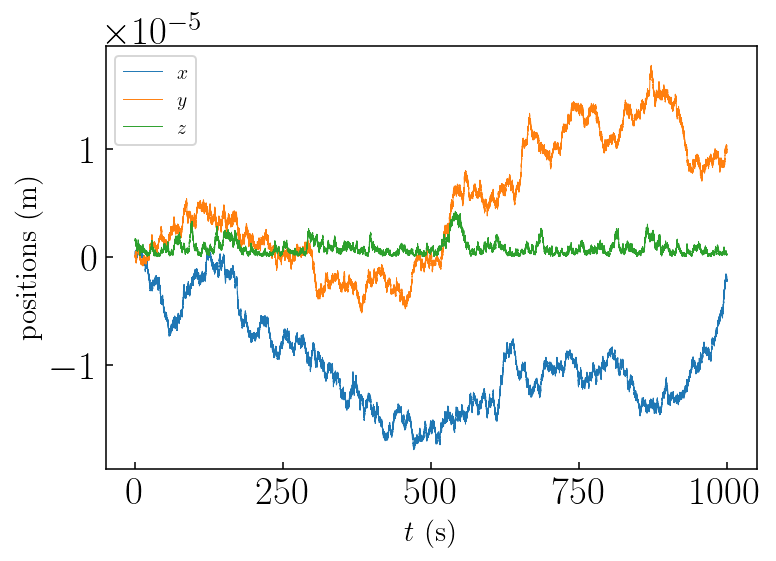

In [4]:
plot_traj(simu.t,Rs)

## 3. plot PDF

### 3.a) $P_\mathrm{eq}(z)$
La PDF théorique des altitudes $z$ à l'équilibre s'écrit :
\begin{equation}
    P_\mathrm{eq} (z) = N ~ \exp(- B ~ e^{- \frac{z}{l_\mathrm{d}} } - \frac{z}{l_\mathrm{b}} ),
\end{equation}
où $N$ est une constante de normalisation, $l_\mathrm{d}$ la longueur de Debye et $l_\mathrm{b}$ la longueur de Boltzman, $B=4.8$ un facteur déterminer expérimentalement $\color{red}{\mathrm{(À ~vérifier ~!!)}}$.

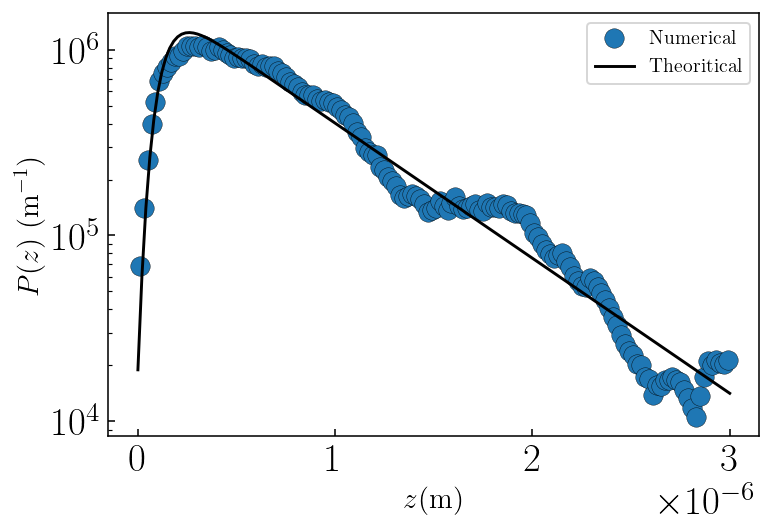

In [5]:
PDF("z", Rs, simu.dt, simu.Nt, lD=simu.lD, lB=simu.lB, space="wall", bins=150)

On peut calculer la valeur moyenne des coeficients de diffusion collinaire et transverse à l'aide de $P_\mathrm{eq}(z)$ :
\begin{equation}
    \langle D_i \rangle_z = \int_{-\infty}^{+\infty} D_i ~ P_\mathrm{eq}(z) \mathrm{d}z .
\end{equation}

In [6]:
zth = np.linspace(1e-7, 3e-6, 200) ## Une liste de z
pdf_theo = P_z_wall(zth, 1, 4.8, simu.lD, simu.lB) ## P_eq(z)
Peq_z = pdf_theo/np.trapz(pdf_theo, zth) ## Normalisation par N

""" 
    Sur l'axe Z
"""
Dz = (simu.kb*simu.T) / (simu._gamma_z(zth)) ## D_\perp (z)
mean_Dz_theo = np.trapz(Dz * Peq_z, zth) ## <D_\perp (z)>
print("<Dz>_theo/D_0 = {:.2f}".format(mean_Dz_theo/(simu.kb * simu.T / simu.gamma)))

""" 
    Sur l'axe X
"""
Dx = (simu.kb*simu.T) / (simu._gamma_xy(zth)) ## D_|| (z)
mean_Dx_theo = np.trapz(Dx * Peq_z, zth)  ## <D_|| (z)>
print("<Dx>_theo/D_0 = {:.10f}".format(mean_Dx_theo/(simu.kb * simu.T / simu.gamma)))

<Dz>_theo/D_0 = 0.28
<Dx>_theo/D_0 = 0.6028324441


### 3.b) $P(\Delta x_i, \tau)$, $x_i = \{ x,y,z \}$.

La PDF des déplacement en $x$, $y$ et $z$ sont données par la relation: 


\begin{equation}
    P(\Delta x_i, \tau) = \frac{1}{N} \int_{-\infty}^{+\infty} P(D_i) \exp \left( -\frac{\Delta x_i^2}{4 D_i \tau} \right) \mathrm{d}D_i,
\end{equation}
où le déplacement est calculé à partir du retard $\tau$ tel que $\Delta x_i = x_i(t+\tau)-x_i(t)$ et $N$ est le facteur de normalisation.

La PDF des coeficients de disctributioin est donnée par :

\begin{equation}
    P(D_i) = \int_{-\infty}^{+\infty} D_i(z)~ P_\mathrm{eq}(z) \mathrm{d}z
\end{equation}


In [7]:
def pdf(data, bins = 50, density = True):
    #PDF(data)
    
    pdf, bins_edge = np.histogram(data, bins = bins, density = density)
    bins_center = (bins_edge[0:-1] + bins_edge[1:]) / 2
    
    return pdf, bins_center 

def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

##################################################
# Calcul théo de la PDF(Delta xi, Delta t) avec le mur -> D(z) non constant

def pdf_Di(axis="z"):
    """
    Calcul la PDF(Di)
    """
    z = np.linspace(1e-10, 10e-6, 1000)
    
    if axis == "z":
        Di = simu.kb*simu.T/simu._gamma_z(z)
    
    else:
        Di = simu.kb*simu.T/simu._gamma_xy(z)
#         z = np.linspace(-10e-6, 10e-6, 1000)
        
    pdf_xi = P_z_wall(z, 1, 4, simu.lD, simu.lB)
    
    return Di, Di*pdf_xi

def f_to_integrate(dz,n_dt, axis="z"):
    """
    Calcul de la fonction à intégrer pour 1 dt donnée
    """
    Di, PDi = pdf_Di(axis)
    f = PDi * 1/np.sqrt(4*np.pi*Di*n_dt*simu.dt) * np.exp(-dz**2/(4*Di*n_dt*simu.dt))

    return f, Di

def _pdf_DeltaXi_Delta_t(dz, n_dt, axis="z"):
    """
    Calcul de l'intégrale pour 1 Di.
    """
    f, Di = f_to_integrate(dz, n_dt, axis=axis)
    non_normalised = np.trapz(f, Di)
        
    return non_normalised

def pdf_DeltaXi_Delta_t(dz, n_dt, axis="z"):
    """
    Calcul de l'intégrale pour une liste Di.
    """
    A = 1
    Di = f_to_integrate(dz,n_dt, axis=axis)[1] #on récupère Di
    result = np.zeros(len(dz))
    
    for i in range(len(dz)):
        result[i] = _pdf_DeltaXi_Delta_t(dz[i], n_dt, axis=axis)
    
    A = 1/np.trapz(result, dz)
    
    return A*result


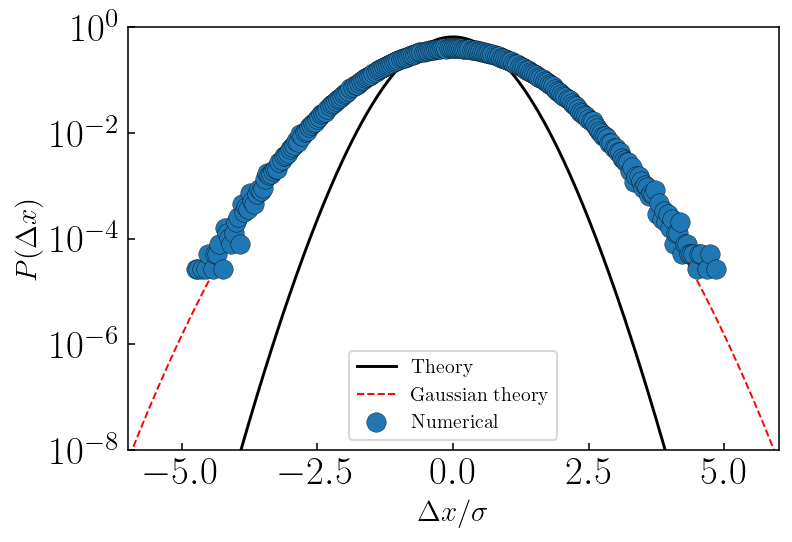

In [41]:
N_tau = 10

Di = pdf_Di(axis="x")[0]
dx = np.linspace(-5e-7, 5e-7, len(Di))
PDF_X =  pdf_DeltaXi_Delta_t(dx,i, axis="x")

x_theo = np.linspace(-7, 7, 1000)
gaussian_theo = gauss_function(x_theo, 1, 0, 1)
gaussian_theo = gaussian_theo * 1/np.trapz(gaussian_theo, x_theo)
    
std = np.std(simu.x[0:-N_tau] - simu.x[N_tau:])
    
plt.plot(dx/std, PDF_X/np.trapz(PDF_X, dx/std), "k", label="Theory")
plt.semilogy(x_theo, gaussian_theo, "--", color="red",linewidth=1., label="Gaussian theory")
plt.axis([-6, 6, 1e-8, 1])
PDF("dx", Rs, simu.dt, simu.Nt, D=mean_Dx_theo, lD=simu.lD, lB=simu.lB, N_tau=N_tau, space="wall", bins=250)

Text(0, 0.5, '$PDF(\\Delta x)$')

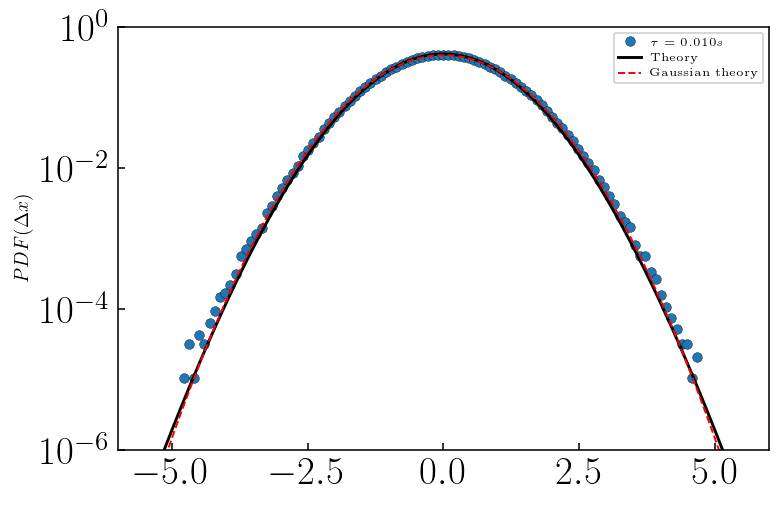

In [59]:
## PDF Dx (all time)

Di = pdf_Di(axis="x")[0]
dx = np.linspace(-5e-7, 5e-7, len(Di))

i = 10

Dezs = (simu.x[0:-i] - simu.x[i:])
std = np.std(Dezs)
Dezs = Dezs / std #division par standard déviation
hist, bins_center = pdf(Dezs, bins = 100)
plt.semilogy(bins_center, hist, ".",label = r"$\tau ={:.3f} s$".format(simu.t[i]))
PDF_X =  pdf_DeltaXi_Delta_t(dx,i, axis="x")
plt.semilogy(dx/std, PDF_X/np.trapz(PDF_X, dx/std), "k", label="Theory")
    

    
x_theo = np.linspace(-5.5, 5.5, 1000)
gaussian_theo = gauss_function(x_theo, 1, 0, 1)
gaussian_theo = gaussian_theo * 1/np.trapz(gaussian_theo, x_theo)
    
plt.semilogy(x_theo, gaussian_theo, "--", color="red",linewidth=1., label="Gaussian theory")
plt.axis([-6, 6, 1e-6, 1])

plt.legend(fontsize="xx-small")
plt.ylabel("$PDF(\Delta x)$")

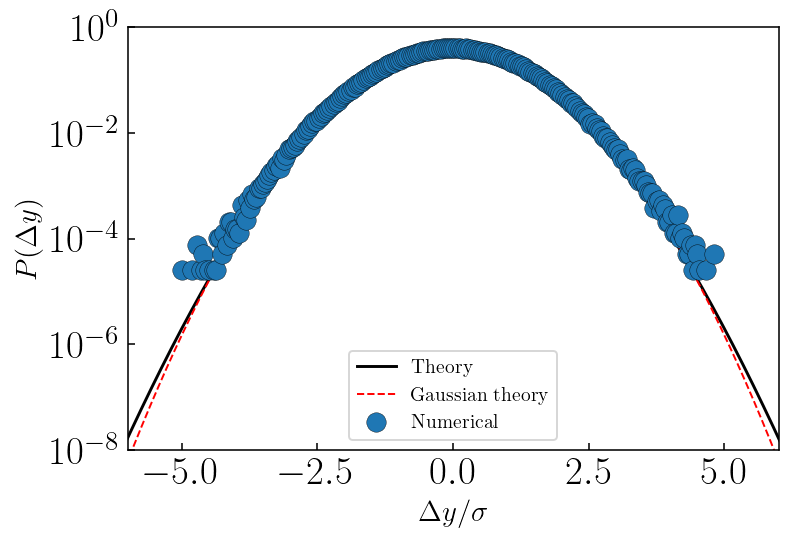

In [27]:
Di = pdf_Di(axis="y")[0]
dx = np.linspace(-5e-7, 5e-7, len(Di))
PDF_X =  pdf_DeltaXi_Delta_t(dx,i, axis="y")

x_theo = np.linspace(-7, 7, 1000)
gaussian_theo = gauss_function(x_theo, 1, 0, 1)
gaussian_theo = gaussian_theo * 1/np.trapz(gaussian_theo, x_theo)
    

plt.plot(dx/std, PDF_X/np.trapz(PDF_X, dx/std), "k", label="Theory")
plt.semilogy(x_theo, gaussian_theo, "--", color="red",linewidth=1., label="Gaussian theory")
plt.axis([-6, 6, 1e-8, 1])
PDF("dy", Rs, simu.dt, simu.Nt, D=mean_Dx_theo, lD=simu.lD, lB=simu.lB, N_tau=10, space="wall", bins=250)

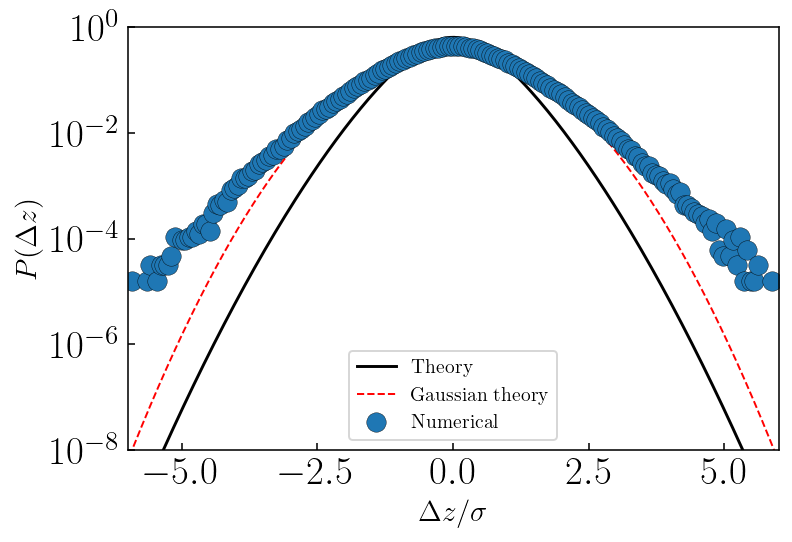

In [31]:
Di = pdf_Di(axis="z")[0]
dx = np.linspace(-5e-7, 5e-7, len(Di))
PDF_X =  pdf_DeltaXi_Delta_t(dx,i, axis="z")

x_theo = np.linspace(-7, 7, 1000)
gaussian_theo = gauss_function(x_theo, 1, 0, 1)
gaussian_theo = gaussian_theo * 1/np.trapz(gaussian_theo, x_theo)
    

plt.plot(dx/std, PDF_X/np.trapz(PDF_X, dx/std), "k", label="Theory")
plt.semilogy(x_theo, gaussian_theo, "--", color="red",linewidth=1., label="Gaussian theory")
plt.axis([-6, 6, 1e-8, 1])

PDF("dz", Rs, simu.dt, simu.Nt, D=mean_Dz_theo, lD=simu.lD, lB=simu.lB, N_tau=10, space="wall", bins=200)

## 4. PLot MSD

100%|██████████| 54/54 [00:00<00:00, 357.93it/s]


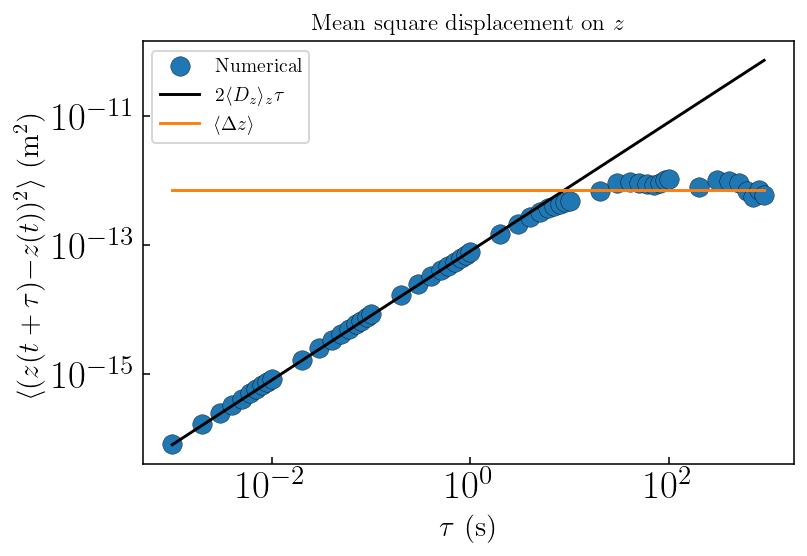

In [16]:
MSD("z", Rs, simu.dt, simu.Nt, D_mean=mean_Dz_theo, lD=simu.lD, lB=simu.lB, space="wall")

## 5. Cumulant ordre 4

\begin{equation}
    C^{(4)} = \frac{1}{4!}\left( \langle z(t)-z(t+\tau) \rangle^4 - 3 \langle (z(t)-z(t+\tau)^2 \rangle^2 \right)
\end{equation}

In [ ]:
mean_Dx2_theo = np.trapz(Dx**2*Peq_z, zth)
facteur_cumulant = (mean_Dx2_theo - mean_Dx_theo**2)/2
print(facteur_cumulant)

In [ ]:
list_dt_c4 = np.array([], dtype=int)
for i in range(len(str(Nt)) - 3):
    # Take just 10 points by decade.
    list_dt_c4 = np.concatenate(
        (
            list_dt_c4,
            np.arange(10 ** i, 10 ** (i + 1), 10 ** i, dtype=int),
        )
    )

In [ ]:
NumberOfMSDPoint = len(list_dt_c4)
c4 = np.zeros(NumberOfMSDPoint) #Notre pote, cumulant d'ordre 4
position = Rs[:, 0]
axis = "x"

In [ ]:
for k, i in enumerate(tqdm(list_dt_c4)):
    if i == 0:
        c4[k] = 0
        continue
    c4[k] =(np.mean((position[i:]-position[:-i])**4) - 3*(np.mean((position[i:]-position[:-i])**2))**2) * 1/(24)

In [ ]:
plt.loglog(simu.t[list_dt_c4], c4, "o", label=r"$\mathrm{Numerical}$")
plt.xlabel(r"$\tau$ $(\mathrm{s})$", fontsize=15)
plt.ylabel(r"$C^{(4)}$", fontsize=15)
ax = plt.gca()
locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0,), numticks=100)
ax.xaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=100)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())


locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0,), numticks=100)
ax.yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=100)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

tth = np.linspace(1e-3,10)
plt.plot(tth, facteur_cumulant* tth**2, label=r"$(\langle D_{\|, \mathrm{th}}^2 \rangle - \langle D_{\|, \mathrm{th}} \rangle^2)/2$")


plt.legend()
plt.show()


### vérifier quand theorie en t² et en t se croise = $\tau_4$-> voir le code d'Arthur

### faire avec cython pour aller plus loin et vérifier la linéarité au temps long $\tau >> \tau_4$
